In [1]:
# !export FIFTYONE_DEFAULT_APP_ADDRESS=cadmium
# !export FIFTYONE_DATABASE_URI=mongodb://cadmium:27017

# mongodb://[username:password@]host[:port]

In [1]:
import fiftyone as fo
import pandas as pd
import numpy as np
import math 
import fiftyone.brain as fob
from fiftyone import ViewField as F
import fiftyone.zoo as foz
import cv2
import plotly.express as px

In [2]:
#!pip install "notebook>=5.3" "ipywidgets>=7.5"

# Notebook to split the dataset using different approaches 
See https://esmartcontrol.atlassian.net/wiki/spaces/ES/pages/2342420485/YoloV5+Multitasks#Data-splits

In [3]:
dataset = fo.load_dataset("esmart_context")

In [4]:
dataset = dataset.exists("gt_road_condition")


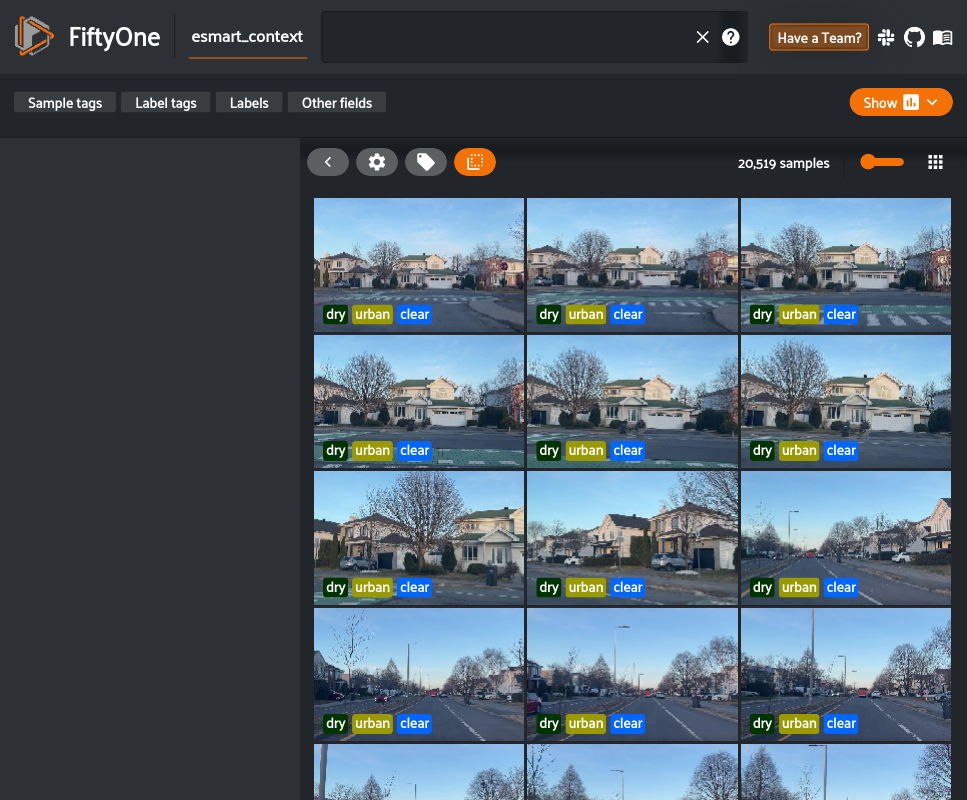

Dataset:          esmart_context
Media type:       image
Num samples:      20519
Selected samples: 0
Selected labels:  0
Session URL:      http://localhost:5151/
View stages:
    1. Exists(field='gt_road_condition', bool=True)

In [5]:
fo.launch_app(dataset, port=5151)

In [ ]:
def analyze_sequences_fiftyone():
    """Analyze the different sequences in the 51 dataset 
    Returns a df with a count of frames per sequence.
    """
    filepath_list = []
    seq_list = []
    frame_list = []
    for sample in dataset:
        if 'ambiguous_road_cond' not in sample.tags:
            file_path = sample.filepath
            file_name = sample.filepath.split("/")[-1]
    #         print(file_name)
            file_name_splitted = file_name.split("_")
    #         print(file_name_splitted)
            sequence_ls = file_name_splitted[:-1]
            sequence = "".join(map(str, sequence_ls))
            frame = file_name_splitted[-1].split(".")[:-1]
            filepath_list.append(file_path)
            seq_list.append(sequence)
            frame_list.append(frame)
    sequences_tuples = list(zip(filepath_list, seq_list, frame_list))
    sequences_df = pd.DataFrame(sequences_tuples, columns=["Filepath", "Sequence", "Frame"])
#     sequences_df.sort_values(["Sequence", "Frame"], inplace=True)
#     print(sequences_df.groupby(["Sequence"]).count().shape)
# convert the frame id from a list of string to an integer
    sequences_df['Frame'] = sequences_df['Frame'].apply(lambda x: int(x[0]))
    sequences_df_grouped = sequences_df.groupby(["Sequence"]).count()
    return sequences_df

In [ ]:
sequences_df = analyze_sequences_fiftyone()

In [ ]:
sequences_df

### Method to delete splits in fiftyone (if needed sometimes)

In [11]:
def delete_tags(data, mapp):
    to_check = list(mapp.values())
    for sample in data:
        for item in to_check:
            if item in sample.tags:
                sample.tags.remove(str(item))
        sample.save()

## 1. Split manually by selecting some validation sequences -- OOD

In [ ]:
def split_train_val_fiftyone_sequences():
    """
    Split the dataset by sequence number (by manually inspecting the properties of the sequences).
    Allows to not have frames from the same sequence in both the training and validation set.
    This is crucial to check whether the algorithm is performant in "new scenes" and doesn't 
    just learns spurrious correlations. 
    """
    list_sequences_val_set = [
        "Log-20220123-124034 Data Log",  # for some snowy and/or wet
        "Log-20220130-104657 Data Log",  # for some snowy and/or wet
        "Log-20220120-181824 Data Log",  # for some snowy and/or wet
        "20210630191429",  # for some dry
        "20210630180005",  # for some dry
        "20210630192517",  # for some dry
        "20211129193841",  # for some dry
        "20210715091801",  # for some dry
        "20211129205422",  # for some dry
        "20210724133321",  # for some dry
        "20210715175810",  # for some dry
        "20210630195611",  # for some dry
        "20210630191006",  # for some dry
    ]

    counter_train = {}
    counter_train["wet"] = 0
    counter_train["dry"] = 0
    counter_train["snowy"] = 0

    counter_val = {}
    counter_val["wet"] = 0
    counter_val["dry"] = 0
    counter_val["snowy"] = 0

    for sample in dataset:
        try:
            condition = sample.gt_road_condition.classifications[0].label
            seq = str(sample.tags[-1])
            if seq in list_sequences_val_set:
                counter_val[condition] += 1
                sample.tags.append("VAL_ROAD_COND")
                sample.save()
            else:
                condition = sample.gt_road_condition.classifications[0].label
                counter_train[condition] += 1
                sample.tags.append("TRAIN_ROAD_COND")
                sample.save()
        except:
            a = 1
    print("TRAIN ", counter_train)
    print("train total", sum(counter_train.values()))
    print("VAL ", counter_val)
    print("val total", sum(counter_val.values()))

if SPLIT_TRAIN_VAL_IN_51:
    split_train_val_fiftyone_sequences()

## 2. Use Subsequences for splitting (by time) -- ID

In [22]:
def check_time_between_2_frames(frame_1, frame_2, num_minutes):
    """
    Function to check whether 2 frames can be used in 2 data sets.
    e.g We want frame_1 in the training set and frame_2 in the validation set. We need to make 
    sure that these are not too close to each other in terms of time otherwise they could be very
    similar and the validation set would be biased. This is not the perfect technique to check the
    independence between frames but that's an approach.
    args: 
        the frame numbers from a same sequence 
        the number of minutes that we want between 2 frames to consider them as "far enough"
            from eaach other (independent enough).
    returns:
        True if we can use these 2 images in 2 sets
        False otherwise
    """
    assert type(frame_1) == type(frame_2) == np.int64
    num_frame_btw = abs(frame_2 - frame_1)
    # approximation
    threshold = num_minutes * 60 * 24
#     print("The chosen time as threshold is", num_minutes,"minutes.")
#     print("There must be at least", threshold,"frames between 2 images to split these in 2 sets.")
    if num_frame_btw >= threshold:
        return True 
    else:
        return False 

In [23]:
# get all the different sequence names
sequences_names = sequences_df['Sequence'].unique()
print("There is", len(sequences_names), "sequences.")

There is 40 sequences.


In [24]:
num_minutes_threshold = 2

empty_list = list(zip([],[],[],[]))
frames_splitted_df = pd.DataFrame(empty_list, columns=["Filepath", "Sequence", "Frame","Set"])

frames_splitted_df

for seq in sequences_names:
    # loc all the rows of a specific sequence
    sequence = sequences_df.loc[sequences_df['Sequence'] == seq].sort_values(['Frame'], 
                                                                             ignore_index=True)
    num_frames = sequence.shape[0]
    print("The sequence", seq, "contains", num_frames, "frames.")
    max_index_training_set = math.floor(num_frames * 0.6)-1  # 60 % of the frames in this data 
    sequence['Set'] = 0
    sequence.loc[:max_index_training_set, 'Set'] = 'train'
    found_first_index_val_set = False
    i = 1
    frame_1 = sequence['Frame'][max_index_training_set]
    print("The maximum index for the train set is", max_index_training_set,". It's the frame", frame_1)
    # print("Frame 1:",frame_1)
    index = max_index_training_set + 1
    while not found_first_index_val_set and index < num_frames:
        frame_2 = sequence['Frame'][index]
        found_first_index_val_set = check_time_between_2_frames(frame_1, frame_2, num_minutes_threshold)
        if found_first_index_val_set:
            min_index_val_set = index
            print("The minimum index for the validation set is", min_index_val_set,". It's the frame", frame_2)
            sequence.loc[min_index_val_set:, 'Set'] = 'val'
            break
        i += 1
        index += i
    if not found_first_index_val_set:
        print("No minimum index found. Try reducing the percentage of data in the training set or the time threshold.")
    frames_to_concat = [frames_splitted_df, sequence]
    frames_splitted_df = pd.concat(frames_to_concat)
    print()

The sequence Log-20220412-190445 Untitled contains 847 frames.
The maximum index for the train set is 507 . It's the frame 16401
The minimum index for the validation set is 612 . It's the frame 19656

The sequence Log-20220412-192914 Untitled contains 806 frames.
The maximum index for the train set is 482 . It's the frame 16371
The minimum index for the validation set is 587 . It's the frame 19626

The sequence Log-20220413-104057 Untitled contains 763 frames.
The maximum index for the train set is 456 . It's the frame 14138
The minimum index for the validation set is 561 . It's the frame 17393

The sequence Log-20220414-064154 Data Log contains 1967 frames.
The maximum index for the train set is 1179 . It's the frame 38876
The minimum index for the validation set is 1270 . It's the frame 43030

The sequence Log-20220419-063722 Data Log contains 1786 frames.
The maximum index for the train set is 1070 . It's the frame 37092
The minimum index for the validation set is 1175 . It's the fr

In [25]:
assert frames_splitted_df.shape[0] == sequences_df.shape[0]

In [26]:
frames_splitted_df

Filepath  \
0    /home/selim/Desktop/esmart-ai-datasets/data/es...   
1    /home/selim/Desktop/esmart-ai-datasets/data/es...   
2    /home/selim/Desktop/esmart-ai-datasets/data/es...   
3    /home/selim/Desktop/esmart-ai-datasets/data/es...   
4    /home/selim/Desktop/esmart-ai-datasets/data/es...   
..                                                 ...   
176  /home/selim/Desktop/esmart-ai-datasets/data/es...   
177  /home/selim/Desktop/esmart-ai-datasets/data/es...   
178  /home/selim/Desktop/esmart-ai-datasets/data/es...   
179  /home/selim/Desktop/esmart-ai-datasets/data/es...   
180  /home/selim/Desktop/esmart-ai-datasets/data/es...   

                         Sequence Frame    Set  
0    Log-20220412-190445 Untitled   684  train  
1    Log-20220412-190445 Untitled   715  train  
2    Log-20220412-190445 Untitled   746  train  
3    Log-20220412-190445 Untitled   777  train  
4    Log-20220412-190445 Untitled   808  train  
..                            ...   ...    ...  
176  Log-20220704-144436 Data Log  2539      0  
177  Log-20220704-144436 Data Log  2539      0  
178  Log-20220704-144436 Data Log  2539      0  
179  Log-20220704-144436 Data Log  2539      0  
180  Log-20220704-144436 Data Log  2539      0  

[20522 rows x 4 columns]

In [27]:
count_split = frames_splitted_df['Set'].value_counts()
df_count = pd.DataFrame(count_split).transpose()
df_count.rename(columns={'train':'Training set', 'val':'Validation set', 0:'Left out'}, inplace=True)

In [28]:
df_count

Training set  Validation set  Left out
Set         12296            5775      2451

In [29]:
fig = px.bar(df_count, title='Distribution of the new data split')
fig.show()

### Save splits in fiftyone

In [30]:
# training/validation road condition automatic based on time 
mapping = {'train':'TRAIN_RC_AUTO_TIME', 'val':'VAL_RC_AUTO_TIME'} 
for sample in dataset:
    if 'ambiguous_road_cond' not in sample.tags:
        data_set = str(list(frames_splitted_df[frames_splitted_df['Filepath'] == sample.filepath]['Set'])[0])
        if data_set != '0':
            sample.tags.append(mapping[data_set])
            sample.save()

### Delete splits in fiftyone (if needed sometimes)

In [21]:
mapping = {'train':'TRAIN_RC_AUTO_TIME', 'val':'VAL_RC_AUTO_TIME'} 
delete_tags(dataset, mapping)

## 7. Split by location using the location plot and the Fiftyone interface to add data set tags - iOD

In [18]:
# pip install "notebook>=5.3" "ipywidgets>=7.5"

In [8]:
location_view = dataset.exists("location")
location_view

Dataset:     esmart_context
Media type:  image
Num samples: 20523
Sample fields:
    id:                fiftyone.core.fields.ObjectIdField
    filepath:          fiftyone.core.fields.StringField
    tags:              fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    location:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.GeoLocation)
    gt_roadtype:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    gt_road_condition: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
    gt_visibility:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classifications)
View stages:
    1. Exists(field='location', bool=True)

In [9]:
session = fo.launch_app(location_view, port=5151)

In [10]:
# A list of ``[longitude, latitude]`` coordinates
locations = location_view.values("location.point.coordinates")

# Scalar `uniqueness` values for each sample
#uniqueness = dataset.values("uniqueness")

# road_cond = ["dry" if "dry" in sample.gt_road_condition.classifications[0].label else
#              "train" for sample in location_view]
# The number of ground truth objects in each sample
num_objects = location_view.values(F("ground_truth.detections").length())

# Create scatterplot
plot = fo.location_scatterplot(
    #locations=locations,
    samples=location_view,
#     labels=validation,      # color points by their `uniqueness` values
    sizes=num_objects,      # scale point sizes by number of objects
    labels_title="uniqueness",
    sizes_title="objects",
)
plot.show()
session.plots.attach(plot)

FigureWidget({
    'data': [{'customdata': array(['62e0098fec79d06bfc54e8a4', '62e00990ec79d06bfc54e8ad',
    …

In [20]:
print(len(num_objects))

1749


In [ ]:
# WIP

In [31]:
# # A list of ``[longitude, latitude]`` coordinates
# locations = location_view.values("location.point.coordinates")
# # locations = list(filter(None, locations))  # remove None locations from the list

# # Scalar `uniqueness` values for each sample
# ids_list = dataset.values('id')
# ids = np.array(dataset.values('id'))
# unique = np.unique(ids)
# num_values = len(unique)
# # print(num_values)

# # # The number of ground truth objects in each sample
# num_objects = dataset.values(F("ground_truth.detections").length())
# # print(len(num_objects))

# # assert len(locations) == len(num_objects) == num_values


# data = list(zip(locations, ids_list, num_objects))
# data_df = pd.DataFrame(data, columns=["location", "id", "num_object"])
# data_df.dropna(inplace=True)
# locations = list(data_df['location'])
# ids = list(data_df['id'])
# num_objects = list(data_df['num_object'])

# data_df
# # # Create scatterplot
# plot = fo.location_scatterplot(
#     locations=locations,
#     labels=ids,      # color points by their `uniqueness` values
#     sizes=num_objects,      # scale point sizes by number of objects
#     labels_title="uniqueness",
#     sizes_title="objects",
# )
# plot.show(height=720)
# # session.view()
# session.plots.attach(plot)

## 3. Shuffle the images from all sequences and split by images (randomly) + apply similarity threshold for include/exclude in the val set — ID

### Compute the embeddings of the train set 

In [6]:
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz

In [20]:
train_set = dataset.match_tags("TRAIN_RC_AUTO_TIME")
val_set = dataset.match_tags("VAL_RC_AUTO_TIME")

### Compute the embeddings

In [7]:
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")
embeddings = dataset.compute_embeddings(model)

/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 100% |█████████████| 20523/20523 [4.4m elapsed, 0s remaining, 71.9 samples/s]       


### Visualize the embedded space

In [48]:
# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    num_dims=2,
    brain_key="image_embeddings",
    verbose=True,
    seed=51,
)

/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.



Computing embeddings...
 100% |█████████████| 20519/20519 [7.0m elapsed, 0s remaining, 52.8 samples/s]       
Generating visualization...
UMAP(n_components=10, random_state=51, verbose=True)
Fri Aug  5 15:06:18 2022 Construct fuzzy simplicial set
Fri Aug  5 15:06:18 2022 Finding Nearest Neighbors
Fri Aug  5 15:06:18 2022 Building RP forest with 12 trees
Fri Aug  5 15:06:19 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Fri Aug  5 15:06:19 2022 Finished Nearest Neighbor Search
Fri Aug  5 15:06:19 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Aug  5 15:06:34 2022 Finished embedding


In [ ]:
session = fo.launch_app(dataset)

In [ ]:
# Visualize image embeddings colored by gt_road_condition
plot = results.visualize(
#     labels="gt_road_condition.label",
#     labels_title="Road condition",
    labels='gt_road_condition.classifications.label',
    labels_title="Road Condition",
    axis_equal=True,
)
plot.show(height=512)

# Attach plot to session
session.plots.attach(plot)

### Compute uniqueness of the images

In [14]:
fob.compute_uniqueness(dataset)

 100% |████|  100.6Mb/100.6Mb [238.4ms elapsed, 0s remaining, 421.9Mb/s]      
Computing embeddings...
  17% |██|----------|  3440/20519 [4.3s elapsed, 20.4s remaining, 1.1K samples/s]    

/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/fiftyone/utils/torch.py:689: RuntimeWarning: overflow encountered in exp
  odds = np.exp(logits)
/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/fiftyone/utils/torch.py:690: RuntimeWarning: invalid value encountered in true_divide
  odds /= np.sum(odds, axis=1, keepdims=True)


 100% |█████████████| 20519/20519 [17.0s elapsed, 0s remaining, 1.4K samples/s]      
Computing uniqueness...
Computing neighbors for 20519 embeddings; this may take awhile...
Uniqueness computation complete



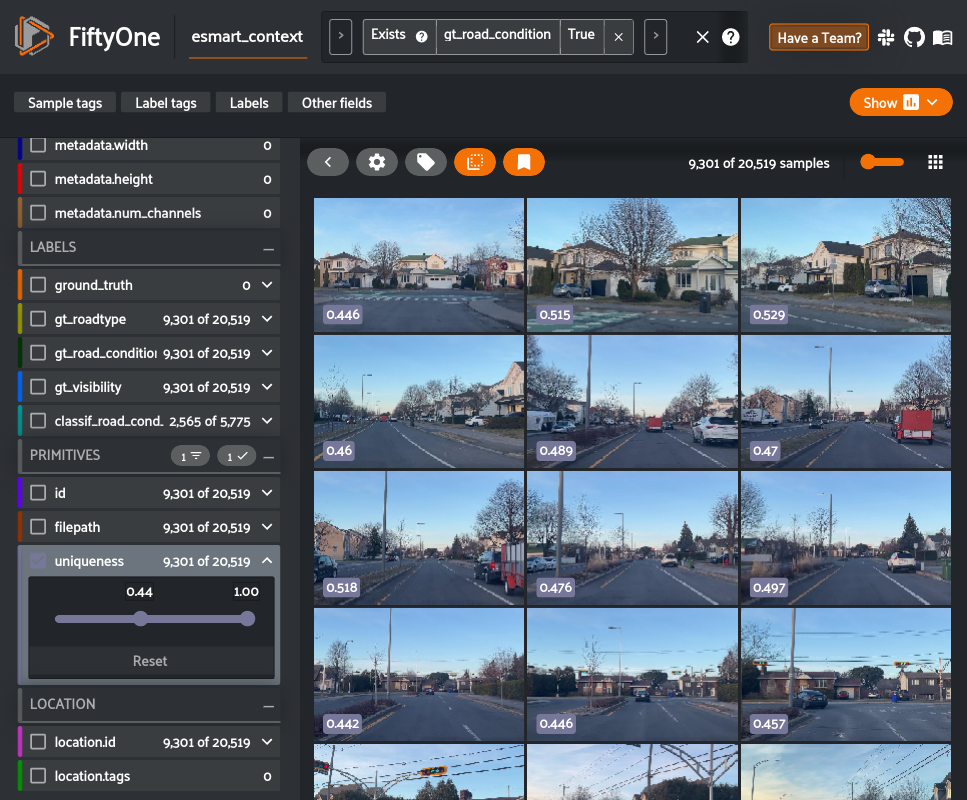

In [16]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness")

# Open view in the App
session.view = dups_view

### Query by similarity


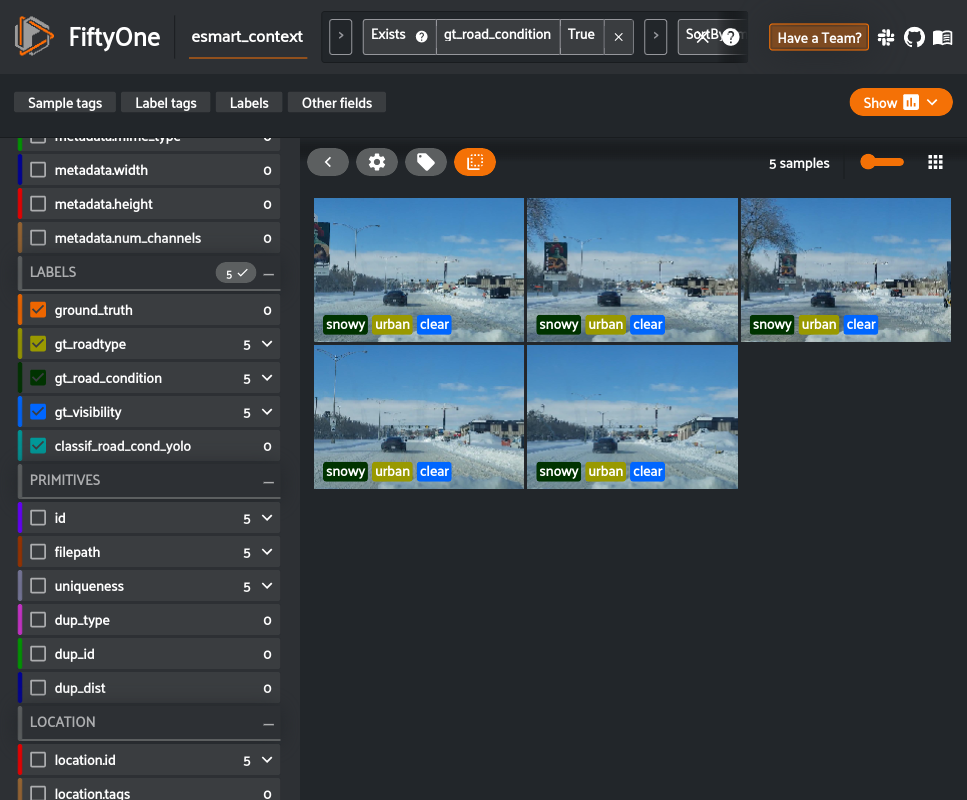

In [37]:
# Choose a random image from the dataset
query_id = dataset.take(1).first().id

# Programmatically construct a view containing the 5 most similar images
view = dataset.sort_by_similarity(query_id, k=5, brain_key="image_sim")

# View results in App
session.view = view

### Sort by uniqueness 

In [38]:
# Show least unique images first
least_unique_view = dataset.sort_by("uniqueness", reverse=False)

# Open view in App
session.view = least_unique_view

### Find possible annotation mistakes 

In [ ]:
fob.compute_mistakenness(
    val_set, "classif_road_cond_yolo", label_field="gt_road_condition"
)

In [ ]:
# Get samples for which we added predictions
h_view = dataset.match_tags("VAL_RC_AUTO_TIME")

# Compute mistakenness
fob.compute_mistakenness(h_view, pred_field= "classif_road_cond_yolo", label_field="gt_road_condition", use_logits=False)

# Sort by likelihood of mistake (most likely first)
mistake_view = (dataset
    .match_tags("VAL_RC_AUTO_TIME")
    .sort_by("mistakenness", reverse=True)
)

# Print some information about the view
print(mistake_view)

# Inspect the first few samples
print(mistake_view.head())

# Show the samples we processed in rank order by the mistakenness
session.view = mistake_view

session.freeze() # screenshot the active App for sharing

### Compute hardness of samples

In [ ]:
fob.compute_hardness(val_set, "classif_road_cond_yolo")

### Find neighbors using the similarity measure

In [28]:
import fiftyone.brain as fob
import fiftyone.brain.internal.models as fbm

# Compute embeddings via a pre-trained CIFAR-10 classifier
model = fbm.load_model("simple-resnet-cifar10")
embeddings = dataset.compute_embeddings(model, batch_size=16)

# Generate similarity index
results = fob.compute_similarity(
    dataset, embeddings=embeddings, brain_key="img_sim"
)

# Generate a 2D visualization
viz_results = fob.compute_visualization(
    dataset, embeddings=embeddings, brain_key="img_viz"
)

  18% |██\----------|  3632/20519 [4.2s elapsed, 18.2s remaining, 1.3K samples/s]    

/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/fiftyone/utils/torch.py:689: RuntimeWarning: overflow encountered in exp
  odds = np.exp(logits)
/home/selim/Desktop/yolov5_multitask/venv/lib/python3.8/site-packages/fiftyone/utils/torch.py:690: RuntimeWarning: invalid value encountered in true_divide
  odds /= np.sum(odds, axis=1, keepdims=True)


 100% |█████████████| 20519/20519 [15.8s elapsed, 0s remaining, 1.6K samples/s]      
Generating visualization...
UMAP( verbose=True)
Fri Aug  5 17:30:44 2022 Construct fuzzy simplicial set
Fri Aug  5 17:30:44 2022 Finding Nearest Neighbors
Fri Aug  5 17:30:44 2022 Building RP forest with 12 trees
Fri Aug  5 17:30:44 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Aug  5 17:30:52 2022 Finished Nearest Neighbor Search
Fri Aug  5 17:30:53 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Aug  5 17:30:59 2022 Finished embedding


In [29]:
# Use the similarity index to identify 500 maximally unique images
results.find_unique(500)
print(results.unique_ids[:5])

Generating neighbors graph for 20519 embeddings; this may take awhile...
Index complete
Computing unique samples...
threshold: 1.000000, kept: 19566, target: 500
threshold: 2.000000, kept: 19416, target: 500
threshold: 4.000000, kept: 17789, target: 500
threshold: 8.000000, kept: 4030, target: 500
threshold: 16.000000, kept: 43, target: 500
threshold: 12.000000, kept: 300, target: 500
threshold: 10.000000, kept: 1060, target: 500
threshold: 11.000000, kept: 530, target: 500
threshold: 11.500000, kept: 415, target: 500
threshold: 11.250000, kept: 463, target: 500
threshold: 11.125000, kept: 500, target: 500
Uniqueness computation complete
['62e0098fec79d06bfc54e8a4', '62e00997ec79d06bfc54e919', '62e009abec79d06bfc54ea03', '62e009acec79d06bfc54ea1e', '62e009c1ec79d06bfc54eb2c']


In [30]:
# Use the similarity index to identify the 1% of images that are least
# visually similar w.r.t. the other images
results.find_duplicates(fraction=0.01)

print(results.neighbors_map)

Computing duplicate samples...
threshold: 1.000000, kept: 19566, target: 20314
threshold: 0.500000, kept: 19633, target: 20314
threshold: 0.250000, kept: 19663, target: 20314
threshold: 0.125000, kept: 19665, target: 20314
threshold: 0.062500, kept: 19665, target: 20314
threshold: 0.031250, kept: 19665, target: 20314
threshold: 0.015625, kept: 19665, target: 20314
threshold: 0.007812, kept: 19665, target: 20314
threshold: 0.003906, kept: 19666, target: 20314
threshold: 0.001953, kept: 19666, target: 20314
threshold: 0.000977, kept: 19666, target: 20314
threshold: 0.000488, kept: 19666, target: 20314
threshold: 0.000244, kept: 19666, target: 20314
threshold: 0.000122, kept: 19666, target: 20314
threshold: 0.000061, kept: 19666, target: 20314
threshold: 0.000031, kept: 19666, target: 20314
threshold: 0.000015, kept: 19666, target: 20314
threshold: 0.000008, kept: 19666, target: 20314
threshold: 0.000004, kept: 19666, target: 20314
threshold: 0.000002, kept: 19666, target: 20314
threshold


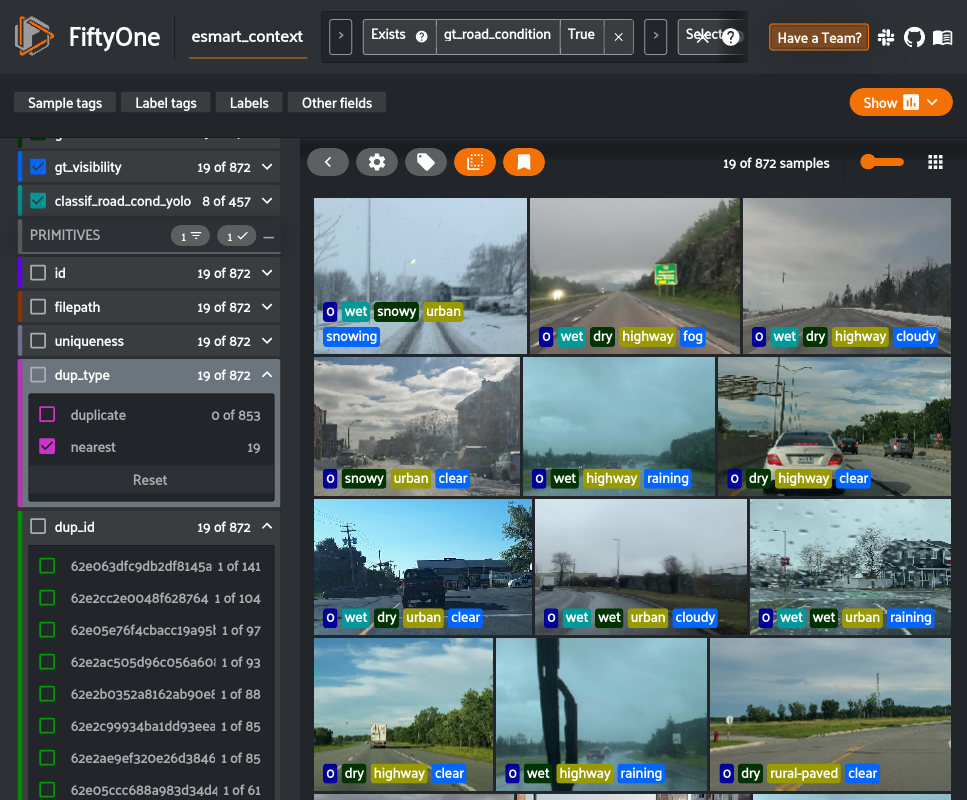

In [35]:
duplicates_view = results.duplicates_view(
    type_field="dup_type",
    id_field="dup_id",
    dist_field="dup_dist",
)

session.view = duplicates_view

In [44]:
# Visualize the unique images in embeddings space
plot = results.visualize_unique(visualization=viz_results)
plot.show(height=800, yaxis_scaleanchor="x")

FigureWidget({
    'data': [{'customdata': array(['62e011d43142b02d8638d4a8', '62e011d43142b02d8638d4b1',
    …

In [22]:
# WIP

## 5. Shuffle the images from all sequences and split by images (randomly) — fully – ID

In [8]:
#sequences_df.to_csv('sequences.csv', header=None)
random_set_df = sequences_df
random_set_df.head()

Filepath        Sequence  Frame
0  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11004
1  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11010
2  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11232
3  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11856
4  /home/admin/data/esmart_wip/20210629_173500_12...  20210629173500  12156

In [9]:
rand_val_set = random_set_df.sample(frac=0.2, replace=False)  # random frames in validation set using a %
rand_val_set['Set'] = 'val'

In [10]:
rand_train_set = random_set_df.loc[~random_set_df.index.isin(rand_val_set.index)]
rand_train_set['Set'] = 'train'

/tmp/ipykernel_147746/3363224728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rand_train_set['Set'] = 'train'


In [11]:
print(rand_val_set.shape)
rand_val_set.head()

(1345, 4)


Filepath  \
6270  /home/raphael/esmart/esmart-ai-datasets/data/e...   
2839  /home/admin/data/esmart_wip/20210807_104028_24...   
744   /home/admin/data/esmart_wip/20210630_180812_19...   
758   /home/admin/data/esmart_wip/20210630_180812_61...   
3748  /home/admin/data/esmart_wip/2021_11_23_alex_da...   

                          Sequence  Frame  Set  
6270  Log-20220121-134942 Data Log  23249  val  
2839                20210807104028   2496  val  
744                 20210630180812  19272  val  
758                 20210630180812    612  val  
3748           20211123alexdashcam    259  val

In [12]:
print(rand_train_set.shape)
rand_train_set.head()

(5380, 4)


Filepath        Sequence  Frame  \
0  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11004   
1  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11010   
4  /home/admin/data/esmart_wip/20210629_173500_12...  20210629173500  12156   
5  /home/admin/data/esmart_wip/20210629_173500_12...  20210629173500  12480   
6  /home/admin/data/esmart_wip/20210629_173500_13...  20210629173500  13140   

     Set  
0  train  
1  train  
4  train  
5  train  
6  train

In [13]:
frames_to_concat = [rand_train_set, rand_val_set]
random_split = pd.concat(frames_to_concat)
random_split

Filepath  \
0     /home/admin/data/esmart_wip/20210629_173500_11...   
1     /home/admin/data/esmart_wip/20210629_173500_11...   
4     /home/admin/data/esmart_wip/20210629_173500_12...   
5     /home/admin/data/esmart_wip/20210629_173500_12...   
6     /home/admin/data/esmart_wip/20210629_173500_13...   
...                                                 ...   
2722  /home/admin/data/esmart_wip/20210807_104028_12...   
6344  /home/raphael/esmart/esmart-ai-datasets/data/e...   
3558  /home/admin/data/esmart_wip/2021_08_12_14_53_2...   
4349             /home/admin/data/esmart_wip/out_42.jpg   
951   /home/admin/data/esmart_wip/20210630_192517_83...   

                          Sequence  Frame    Set  
0                   20210629173500  11004  train  
1                   20210629173500  11010  train  
4                   20210629173500  12156  train  
5                   20210629173500  12480  train  
6                   20210629173500  13140  train  
...                            ...    ...    ...  
2722                20210807104028  12594    val  
6344  Log-20220121-143049 Data Log   6370    val  
3558                20210812145326   4719    val  
4349                           out     42    val  
951                 20210630192517   8352    val  

[6725 rows x 4 columns]

In [14]:
count_split = random_split['Set'].value_counts()
df_count = pd.DataFrame(count_split).transpose()
df_count

train   val
Set   5380  1345

In [18]:
fig = px.bar(df_count, title='Distribution of the new data split')
fig.show()

In [19]:
random_split.to_csv('random_split_22_07_2022.csv')

In [56]:
### Save splits in Fiftyone
to_search = random_split.set_index('Filepath')
# training/validation road condition on random sequence selection
mapping = {'train':'TRAIN_RC_RND_FR', 'val':'VAL_RC_RND_FR'} 
for sample in dataset:
    try:
        split = to_search.loc[sample.filepath].Set
    except:
        print(sample.filepath)
    assert split == 'train' or split == 'val'
    sample.tags.append(mapping[split])
#     sample.save()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Delete splits in fiftyone (if needed sometimes)

In [55]:
mapping = {'train':'TRAIN_RC_RND_FR', 'val':'VAL_RC_RND_FR'} 
to_check = list(mapping.values())
for sample in dataset:
    for item in to_check:
        if item in sample.tags:
#             print(sample.tags)
#             print('yes')
            sample.tags.remove(str(item))
            print(sample.tags)
#             sample.save()
   

## 6. Split Automatically (computer) by randomly selecting some validation sequences -- OOD 

In [89]:
sequences_df.head()

Filepath        Sequence  Frame
0  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11004
1  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11010
2  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11232
3  /home/admin/data/esmart_wip/20210629_173500_11...  20210629173500  11856
4  /home/admin/data/esmart_wip/20210629_173500_12...  20210629173500  12156

In [90]:
rand_seq_split_df = sequences_df

In [117]:
seq_df = rand_seq_split_df.groupby('Sequence').count()
seq_df.head()

Filepath  Frame
Sequence                       
20210629173500       103    103
20210629174553       114    114
20210630055611       226    226
20210630083253       265    265
20210630175841         7      7

In [113]:
val_seq_df = seq_df.sample(frac=0.2, replace=False)  
val_seq_df['Set'] = 'val'
print("There are", val_seq_df.shape[0], "sequences and",val_seq_df['Filepath'].sum(), "frames in the validation set.")

There are 12 sequences and  1870 frames in the validation set.


In [114]:
train_seq_df = seq_df.loc[~seq_df.index.isin(val_seq_df.index)]
train_seq_df['Set'] = 'train'
print("There are", train_seq_df.shape[0], "sequences and", train_seq_df['Filepath'].sum(), "frames in the training set.")

There are 47 sequences and 4855 frames in the training set.


/var/folders/y9/tfgwt38j4vgbjq05myd9zjj80000gn/T/ipykernel_22349/1435915922.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
frames_to_concat = [train_seq_df, val_seq_df]
random_split_seq = pd.concat(frames_to_concat)
random_split_seq.head()

Filepath  Frame    Set
Sequence                              
20210629173500       103    103  train
20210629174553       114    114  train
20210630055611       226    226  train
20210630083253       265    265  train
20210630175841         7      7  train

In [118]:
# TODO: check the classes distribution in these random splits

### Save splits in Fiftyone

In [ ]:
# training/validation road condition on random sequence selection
# mapping = {'train':'TRAIN_RC_RND_SEQ', 'val':'VAL_RC_RND_SEQ'} 
# for sample in dataset:
#     data_set = str(list(random_split_seq['Filepath'] == sample.filepath]['Set'])[0])
# #     print(data_set)
#     if data_set != '0':
#         sample.tags.append(mapping[data_set])
# #         print(sample.tags)
#         # sample.save()
#     break

### Delete splits in fiftyone (if needed sometimes)

In [ ]:
to_check = list(mapping.values())
for sample in dataset:
    for item in to_check:
        if item in sample.tags:
            sample.tags.remove(str(item))
    sample.save()

## 4. Use the sequences from the same location but under different road conditions in the validation set -- ID

In [ ]:
# TODO 